<a href="https://colab.research.google.com/github/ram130849/Data_Structures/blob/main/TensorFlow/Ramki/E533_DLS_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

P1: Network Compression Using SVD

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train/=255
x_test/=255

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(10)
])

In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 10)                1

In [8]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics="acc")

In [10]:
checkpoint_path = "/content/drive/MyDrive/DLS_DATA/assign4/cp-{epoch:02d}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [11]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [12]:
history = model.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=128,
    callbacks=[cp_callback])

Epoch 1/30
468/469 [============================>.] - ETA: 0s - loss: 0.2320 - acc: 0.9292
Epoch 1: saving model to /content/drive/MyDrive/DLS_DATA/assign4/cp-01.hdf5
469/469 [==============================] - 5s 5ms/step - loss: 0.2319 - acc: 0.9292
Epoch 2/30
457/469 [============================>.] - ETA: 0s - loss: 0.0995 - acc: 0.9709
Epoch 2: saving model to /content/drive/MyDrive/DLS_DATA/assign4/cp-02.hdf5
469/469 [==============================] - 2s 5ms/step - loss: 0.0991 - acc: 0.9709
Epoch 3/30
461/469 [============================>.] - ETA: 0s - loss: 0.0733 - acc: 0.9799
Epoch 3: saving model to /content/drive/MyDrive/DLS_DATA/assign4/cp-03.hdf5
469/469 [==============================] - 2s 4ms/step - loss: 0.0735 - acc: 0.9798
Epoch 4/30
463/469 [============================>.] - ETA: 0s - loss: 0.0590 - acc: 0.9833
Epoch 4: saving model to /content/drive/MyDrive/DLS_DATA/assign4/cp-04.hdf5
469/469 [==============================] - 2s 4ms/step - loss: 0.0591 - acc: 0.9

In [13]:
def compress_weights(weight):
    S, U, V = tf.linalg.svd(weight)
    S = tf.linalg.diag(S)
    V = tf.transpose(V)
    return S,U,V

In [14]:
S_list = []
U_list = []
V_list = []
B_list = []
for i in range(1,6):
    weights = model.layers[i].weights[0]
    # print(i,weights)
    bias = model.layers[i].bias.numpy()
    S,U,V = compress_weights(weights)
    S_list.append(S)
    U_list.append(U)
    V_list.append(V)
    B_list.append(bias)

In [15]:
rank_values = [10,20,50,100,200]
acc_val = []
for value in rank_values:
    W_1 = tf.matmul(tf.matmul(U_list[0][:, :value], S_list[0][:value, :value]), V_list[0][:value, :])
    model.get_layer(index=1).set_weights([W_1,B_list[0]])
    W_2 = tf.matmul(tf.matmul(U_list[1][:, :value], S_list[1][:value, :value]), V_list[1][:value, :])
    model.get_layer(index=2).set_weights([W_2,B_list[1]])
    W_3 = tf.matmul(tf.matmul(U_list[2][:, :value], S_list[2][:value, :value]), V_list[2][:value, :])
    model.get_layer(index=3).set_weights([W_3,B_list[2]])
    W_4 = tf.matmul(tf.matmul(U_list[3][:, :value], S_list[3][:value, :value]), V_list[3][:value, :])
    model.get_layer(index=4).set_weights([W_4,B_list[3]])
    W_5 = tf.matmul(tf.matmul(U_list[4][:, :value], S_list[4][:value, :value]), V_list[4][:value, :])
    model.get_layer(index=5).set_weights([W_5,B_list[4]])
    acc_val.append(model.evaluate(x_test,y_test,verbose = 1)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.1492 - acc: 0.9824


In [16]:
W_1 = tf.matmul(tf.matmul(U_list[0], S_list[0]), V_list[0])
W_2 = tf.matmul(tf.matmul(U_list[1], S_list[1]), V_list[1])
W_3 = tf.matmul(tf.matmul(U_list[2], S_list[2]), V_list[2])
W_4 = tf.matmul(tf.matmul(U_list[3], S_list[3]), V_list[3])
W_5 = tf.matmul(tf.matmul(U_list[4], S_list[4]), V_list[4])


model.get_layer(index=1).set_weights([W_1,B_list[0]])
model.get_layer(index=2).set_weights([W_2,B_list[1]])
model.get_layer(index=3).set_weights([W_3,B_list[2]])
model.get_layer(index=4).set_weights([W_4,B_list[3]])
model.get_layer(index=5).set_weights([W_5,B_list[4]])

acc_val.append(model.evaluate(x_test,y_test,verbose = 1)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.1746 - acc: 0.9815


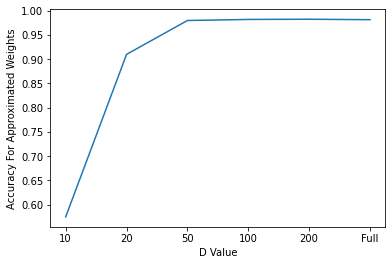

In [17]:
fig, ax = plt.subplots()
ax.plot(acc_val)
ax.set_ylabel("Accuracy For Approximated Weights")
ax.set_xlabel("D Value")
x = [0,10,20,50,100,200,'Full']
ax.set_xticklabels(x)
plt.show()

P2: Network Compression Using SVD

In [18]:
S1,U1,V1 = tf.linalg.svd(model.layers[1].weights[0])
S2,U2,V2 = tf.linalg.svd(model.layers[2].weights[0])
S3,U3,V3 = tf.linalg.svd(model.layers[3].weights[0])
S4,U4,V4 = tf.linalg.svd(model.layers[4].weights[0])
S5,U5,V5 = tf.linalg.svd(model.layers[5].weights[0])

rank = 20

s_1 = tf.linalg.diag(S1)[:rank, :rank]
s_2 = tf.linalg.diag(S2)[:rank, :rank]
s_3 = tf.linalg.diag(S3)[:rank, :rank]
s_4 = tf.linalg.diag(S4)[:rank, :rank]
s_5 = tf.linalg.diag(S5)[:rank, :rank]

v_1 = tf.transpose(V1)[:rank, :]
v_2 = tf.transpose(V2)[:rank, :]
v_3 = tf.transpose(V3)[:rank, :]
v_4 = tf.transpose(V4)[:rank, :]
v_5 = tf.transpose(V5)[:rank, :]


v_s1 = tf.matmul(s_1,v_1)
v_s2 = tf.matmul(s_2,v_2)
v_s3 = tf.matmul(s_3,v_3)
v_s4 = tf.matmul(s_4,v_4)
v_s5 = tf.matmul(s_5,v_5)

u_1 = U1[:, :rank]
u_2 = U2[:, :rank]
u_3 = U3[:, :rank]
u_4 = U4[:, :rank]
u_5 = U5[:, :rank]

B1 = model.layers[1].bias
B2 = model.layers[2].bias
B3 = model.layers[3].bias
B4 = model.layers[4].bias
B5 = model.layers[5].bias

In [19]:
weights =[]
weights.append(u_1)
weights.append(v_s1)
weights.append(u_2)
weights.append(v_s2)
weights.append(u_3)
weights.append(v_s3)
weights.append(u_4)
weights.append(v_s4)
weights.append(u_5)
weights.append(v_s5)

In [20]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),

    tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1024,activation='relu'),

    tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1024,activation='relu'),

    tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1024,activation='relu'),

    tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1024,activation='relu'),

    tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1024,activation='relu'),
    
    tf.keras.layers.Dense(units=10,activation='softmax')
  ])

In [21]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 20)                15700     
                                                                 
 dense_7 (Dense)             (None, 1024)              21504     
                                                                 
 dense_8 (Dense)             (None, 20)                20500     
                                                                 
 dense_9 (Dense)             (None, 1024)              21504     
                                                                 
 dense_10 (Dense)            (None, 20)                20500     
                                                                 
 dense_11 (Dense)            (None, 1024)             

In [22]:
bias = [None]*10
bias[1] = B1
bias[3] = B2
bias[5] = B3
bias[7] = B4
bias[9] = B5
temp_bias = []
for i in range(1,len(model1.layers)-1):
    temp_bias.append(model1.layers[i].bias)
bias[0] = temp_bias[0]
bias[2] = temp_bias[2]
bias[4] = temp_bias[4]
bias[6] = temp_bias[6]
bias[8] = temp_bias[8]

In [23]:
for i in range(len(weights)):
  model1.layers[i+1].set_weights([weights[i],bias[i]])

In [24]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
               metrics=['accuracy'])

In [25]:
history1 = model1.fit(x_train,y_train,epochs = 30, batch_size = 128 )

Epoch 1/30
469/469 [==============================] - 2s 4ms/step - loss: 0.4716 - accuracy: 0.8543
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0889 - accuracy: 0.9785
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0652 - accuracy: 0.9826
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0522 - accuracy: 0.9857
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0430 - accuracy: 0.9877
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0364 - accuracy: 0.9889
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0311 - accuracy: 0.9905
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0267 - accuracy: 0.9916
Epoch 9/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0235 - accuracy: 0.9926
Epoch 10/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0194 - accuracy: 0.9940

In [26]:
test_acc = model1.evaluate(x_test,y_test)
print("Test Accuracy:",test_acc[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.2778 - accuracy: 0.9802
Test Accuracy: 0.9801999926567078


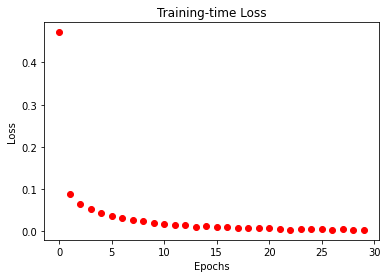

In [34]:
plt.plot(history1.history['loss'],'bo',color='red')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training-time Loss")
plt.show()

P3:  Network Compression Using SVD

P4: Speaker Verification

In [ ]:
b